# Project: Twitter US Airline Sentiment.

### Data Description:

- A sentiment analysis job about the problems of each major U.S. airline. - - - - Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").


### Dataset:

- The project is from a dataset from Kaggle.
- Link to the Kaggle project site: https://www.kaggle.com/crowdflower/twitter-airline-sentiment
- The dataset has to be downloaded from the above Kaggle website.
- The dataset has the following columns:
-  tweet_id
- airline_sentiment
- airline_sentiment_confidence
- negativereason
- negativereason_confidence
- airline
- airline_sentiment_gold
- name
- negativereason_gold
- retweet_count
- text
- tweet_coord
- tweet_created
- tweet_location
- user_timezon


### Objective:

- To implement the techniques learnt as a part of the course.

### Learning Outcomes:
- Basic understanding of text pre-processing.
- What to do after text pre-processing:
- Bag of words
- Tf-idf
- Build the classification model.
- Evaluate the Model.


In [1]:
import tensorflow as tf
import numpy as np
tf.__version__


'2.3.0'

In [2]:
# Import necessary libraries.
import re, string, unicodedata
import pandas as pd
import nltk           
                        # Natural language processing tool-kit
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#!pip install contractions
#import contractions


from bs4 import BeautifulSoup                 # Beautiful soup is a parsing library that can use different parsers.
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet    # Stopwords, and wordnet corpus
from nltk.stem import LancasterStemmer, WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Get Required Files from Drive


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
#Set your project path 
project_path = "/content/drive/My Drive/Colab Notebooks/"



## Reading and Exploring Data

In [5]:
import pandas as pd
df = pd.read_csv(project_path + "Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [7]:
df.shape

(14640, 15)

In [9]:
df.isnull().sum(axis=0) 

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


# Here we are going to deal with text data, so we seperate out the text column in a new dataframe: data
#data = dataset.drop(['airline_sentiment_confidence',
'negativereason_confidence',
'retweet_count',
'tweet_coord',
'tweet_created'], axis=1)

In [12]:
data = df.drop(['airline_sentiment_confidence',
'negativereason_confidence','airline_sentiment_gold','negativereason_gold','tweet_location','negativereason','user_timezone','name',                                  
'retweet_count','tweet_id','airline',
'tweet_coord',
'tweet_created'], axis=1)

In [13]:
# Check first 5 rows of dataframe.
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [15]:
data.shape

(14640, 2)

In [16]:
pd.get_option('display.max_colwidth')

50

In [17]:
# First row of data.
pd.set_option('display.max_colwidth', None) # It will enable the entire row visible with truncation of the text. (We can see full text.)
data.loc[[0]]

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.


### Data Pre-processing:

- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.\
- Remove numbers.
- Tokenization
- To remove Stopwords.
- Lemmatized data

We have used NLTK library to tokenize words , remove stopwords and lemmatize the remaining words.

In [19]:
# Removal of the http link using Regular Expression.
for i, row in data.iterrows():
    clean_text = re.sub(r"http\S+", "", data.at[i, 'text'])
    data.at[i,'text'] = clean_text
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [20]:
#from pycontractions import contractions

In [21]:
'''def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

# Perform the above operation over all the rows of text column of the dataframe.
for i, row in data.iterrows():
    text = data.at[i, 'text']
    clean_text = replace_contractions(text)
    data.at[i,'text'] = clean_text
data.head()'''

'def replace_contractions(text):\n    """Replace contractions in string of text"""\n    return contractions.fix(text)\n\n# Perform the above operation over all the rows of text column of the dataframe.\nfor i, row in data.iterrows():\n    text = data.at[i, \'text\']\n    clean_text = replace_contractions(text)\n    data.at[i,\'text\'] = clean_text\ndata.head()'

In [22]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [23]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# Perform the above operation over all the rows of text column of the dataframe.
for i, row in data.iterrows():
    text = data.at[i, 'text']
    clean_text = decontracted(text)
    data.at[i,'text'] = clean_text
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [24]:
# Tokenize the words of whole dataframe.
for i, row in data.iterrows():
    text = data.at[i, 'text']
    words = nltk.word_tokenize(text)
    data.at[i,'text'] = words
data.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, amp, ;, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


In [25]:
# save the stopwords in a list named stopwords.
stopwords = stopwords.words('english')
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

unicode has characterset for each language
unicodedata: converts non-ascii character to approximate english character as such  
the text should be encoded in ascii format and decoded into utf-8 format  
Any encoding errors ignore those  
Take the text, decode it using utf-8 and then encode it using ascii  
NFKD form goes and identifies approximate english characters  
based on what characters you have in text, accordingly choose the decoding strategy  
i want to approximate to english, thats the reason my encoding happens in ascii  


In [26]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

In [28]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

# Lowercasing

- Lowercasing ALL your text data, although commonly overlooked, is one of the simplest and most effective form of text preprocessing. It is applicable to most text mining and NLP problems and can help in cases where your dataset is not very large and significantly helps with consistency of expected output.

- An example where lowercasing is very useful is for search. Imagine, you are looking for documents containing “usa”. However, no results were showing up because “usa” was indexed as “USA”.

- An example where lowercasing may result in inaccuracy is in predicting the programming language of a source code file. The word System in Java is quite different from system in python. Lowercasing the two makes them identical, causing the classifier to lose important predictive features. While lowercasing is generally helpful, it may not be applicable for all tasks.

In [29]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words

# Stopword Removal:
- Stop words are a set of commonly used words in a language.
- Examples of stop words in English are “a”, “the”, “is”, “are” and etc. The intuition behind using stop words is that, by removing low information words from text, we can focus on the important words instead.

In [30]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        if word not in stopwords:
            new_words.append(word)        # Append processed words to new list.
    return new_words

# Stemming:

- Stemming is the process of reducing inflection in words (e.g. running, runs) to their root form (e.g. run). The “root” in this case may not be a real root word, but just a canonical form of the original word.

In [31]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []                            # Create empty list to store pre-processed words.
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)                # Append processed words to new list.
    return stems

# Lemmatization:

- Lemmatization on the surface is very similar to stemming, where the goal is to remove inflections and map a word to its root form.
- The only difference is that, lemmatization tries to do it the proper way.
- It doesn’t just chop things off, it actually transforms words to the actual root. For example, the word “better” would map to “good”.

In [32]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []                           # Create empty list to store pre-processed words.
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)              # Append processed words to new list.
    return lemmas

### Now it's time to execute the above functions:

### So we define a new function normalize, which processes all the steps together.

In [33]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

In [34]:
# Iterate the normalize funtion over whole data.
for i, row in data.iterrows():
    words = data.at[i, 'text']
    words = normalize(words)
    data.at[i,'text'] = words
data.head()

,airline_sentiment,text
0,neutral,"[virginamerica, dhepburn, said]"
1,positive,"[virginamerica, plus, added, commercials, experience, tacky]"
2,neutral,"[virginamerica, today, must, mean, need, take, another, trip]"
3,negative,"[virginamerica, really, aggressive, blast, obnoxious, entertainment, guests, faces, amp, little, recourse]"
4,negative,"[virginamerica, really, big, bad, thing]"


In [35]:
def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems, lemmas

In [36]:
data['lemma'] = ''
data['stem'] = ''

for i, row in data.iterrows():
    words = data.at[i, 'text']
    stems, lemmas = stem_and_lemmatize(words)
    data.at[i,'stem'] = stems
    data.at[i, 'lemma'] = lemmas
data.head()

,airline_sentiment,text,lemma,stem
0,neutral,"[virginamerica, dhepburn, said]","[virginamerica, dhepburn, say]","[virginameric, dhepburn, said]"
1,positive,"[virginamerica, plus, added, commercials, experience, tacky]","[virginamerica, plus, add, commercials, experience, tacky]","[virginameric, plu, ad, commerc, expery, tacky]"
2,neutral,"[virginamerica, today, must, mean, need, take, another, trip]","[virginamerica, today, must, mean, need, take, another, trip]","[virginameric, today, must, mean, nee, tak, anoth, trip]"
3,negative,"[virginamerica, really, aggressive, blast, obnoxious, entertainment, guests, faces, amp, little, recourse]","[virginamerica, really, aggressive, blast, obnoxious, entertainment, guests, face, amp, little, recourse]","[virginameric, real, aggress, blast, obnoxy, entertain, guest, fac, amp, littl, recours]"
4,negative,"[virginamerica, really, big, bad, thing]","[virginamerica, really, big, bad, thing]","[virginameric, real, big, bad, thing]"


- As we can see here that, the text column contains tokenized words, lemma contains lemmatized words, and stem column contains the stemmed words.
- So, we can use these techniques according to our need of the project as suitable.

In [37]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()               
data_features = vectorizer.fit_transform(df['text'])

data_features = data_features.toarray()                        # Convert the data features to array.

In [38]:
data_features.shape

(14640, 15051)

In [39]:
data_features[0]

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
labels = df['airline_sentiment']

In [41]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

In [42]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7105191256830602


In [43]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)

[[2638  125   51]
 [ 486  354   44]
 [ 246  116  332]]


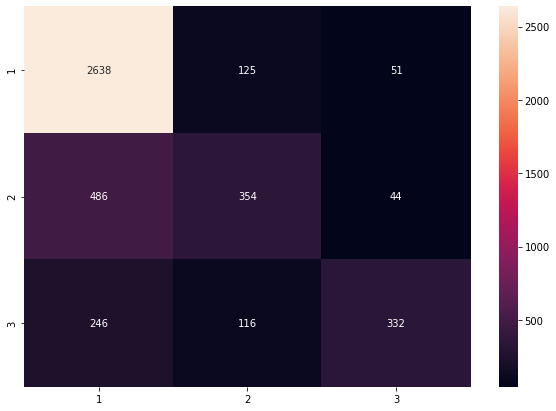

In [44]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [45]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
data_features = vectorizer.fit_transform(df['text'])

data_features = data_features.toarray()

data_features.shape

(14640, 1000)

In [46]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7093579234972678


In [66]:
result = forest.predict(X_test)

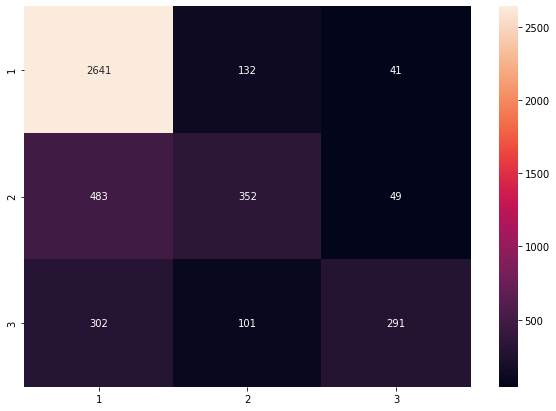

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [56]:
# Using CountVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer()
data_features = vectorizer.fit_transform(df['text'])

data_features = data_features.toarray()

data_features.shape



(14640, 15051)

In [57]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7080601092896174


In [58]:
result = forest.predict(X_test)

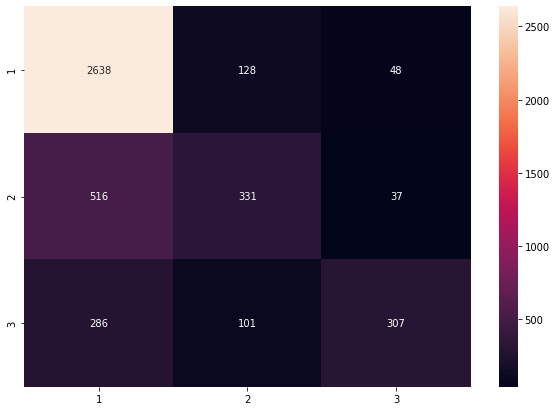

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

Summary:

- We used dataset which has reviews in text format and their sentiment score positive and negative
- The goal was to build a model for text-classification.
- We Pre-processed the data using variuos techniques and libraries.
- The pre-precessed data is converted to numbers, so that we can feed the data in the model.
- After building the classification model, we predicted the result for the test data.
- After that we saw that using the above techniques, our model performed good in perspective of how the text classification models perform.
- Using Random Forest Classifier achieved 71 % Accuracy.
- After Using tfid Vectorizer with Random forest classifier achieved 70.9 percent accuracy.
- After using CountVectorizer with Random Forest classifier achieved 70.8 percent accracy.
- Hence both the methods TfidVectorizer and CountVectorizer achives same accuracy for this dataset.
- Hence this model performs better in predicting the sentiment of US Airline.